# End-to-end processing pipeline
This notebook runs through the full process of going from raw data to running inference on a trained model. The steps are as follows: 

1. Initializing datasets and metadata
2. Processing datasets 
3. Converting datasets into YOLO format
4. Combining and purging YOLO datasets
5. Training a YOLO model
6. Running inference
7. Post-processing and plotting results

Before running this notebook, you will have to download the datasets containing the necessary TIFFs and shapefiles from the GCP bucket and place them as top-level directories in the `data` directory.

In [1]:
import geopandas as gpd
import pandas as pd
from postprocessing import convert_results_to_shp, merge_bboxes, process_results
from preprocessing.dataset import MetaDataset
from preprocessing.utils import ResultsFolderStructure
from preprocessing.yolo import dataset
from utils import shpfile
from yolo_interface.v6.model_configs import TrainYolo6, EvalYolo6
from config import settings

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

data_path = settings.data_path / "all_islands"

## 1. Initializing datasets and metadata

In this step initialize a metadata file and automatically gather datasets within the metadata `data_path` to be added. Only top-level directories within the `data_path` folder with the following structure will be added:

```
example_dataset
├── raw
|   ├── shapefiles
|   |   ├── shapefile1.shp
|   |   ├── shapefile2.shp
|   |   └── ...
|   ├── tifs
|   |   ├── image1.shp
|   |   ├── image2.shp
|   |   └── ...
```

To define datasets manually, see the [create_metadata.py](scripts/create_metadata.py) example.

The populated `metadata.yaml` contains all the necessary information to correctly load and process the datasets.

The `target_resolution` parameter defines the spatial resolution that the image should be rescaled to during processing. We generally find that rescaling images to a consistent resolution improves model performance.

Note: If you get validation errors here it likely means the names of the datasets in the directory and those in the metadata file no longer match. In this case you will have to update the metadata file manually, or overwrite the existing metadata file by setting `overwrite=True` below.

In [2]:
dataset.init_from_data_folder(data_path)

metadata = MetaDataset(
    data_path=data_path,
    filename="metadata.yaml",
    overwrite=True,
)
target_resolution = 0.02  # in meters

Initialising YOLO dataset: shag_melville_train_turret_val
Initialising YOLO dataset: turret2/yolo_dataset
Initialising YOLO dataset: melville3/yolo_dataset


Initialising YOLO dataset: nelson1/yolo_dataset
Initialising YOLO dataset: unnamed_c1/yolo_dataset
Initialising YOLO dataset: fregata1/yolo_dataset
Initialising YOLO dataset: kgi_west2/yolo_dataset
Initialising YOLO dataset: kwarecki1/yolo_dataset
Initialising YOLO dataset: new_islands1/yolo_dataset
Initialising YOLO dataset: shag_extra1/yolo_dataset
Initialising YOLO dataset: shag2/yolo_dataset
Initialising YOLO dataset: turret1/yolo_dataset
Initialising YOLO dataset: melville2/yolo_dataset
Initialising YOLO dataset: shag1/yolo_dataset
Initialising YOLO dataset: rzepecki1/yolo_dataset


Adding datasets within the `data_path` directory to the `metadata.yaml`

In [3]:
metadata.add_from_data_folder(target_resolution=target_resolution, overwrite=True)

Adding directory: /home/jupyter/antarctic-nests/data/all_islands/turret2
For image: Turret_ 22_10_29_redu, using shapefile: all_islands/turret2/raw/shapefiles/22_10_29_Shags_Turret.shp
For image: Turret_22_12_12_redu, using shapefile: all_islands/turret2/raw/shapefiles/2022_12_12_Shags_Turret.shp
Adding directory: /home/jupyter/antarctic-nests/data/all_islands/melville3
For image: Melville_2023_11_11_transparent_mosaic_group1, using shapefile: all_islands/melville3/raw/shapefiles/23_11_11_Melville_Shags.shp
Adding directory: /home/jupyter/antarctic-nests/data/all_islands/nelson1
For image: Nelson, using shapefile: all_islands/nelson1/raw/shapefiles/Shags_Nelson.shp
Adding directory: /home/jupyter/antarctic-nests/data/all_islands/unnamed_c1
For image: Unnamed Island_20161225, using shapefile: all_islands/unnamed_c1/raw/shapefiles/shag_nest_position.shp
Adding directory: /home/jupyter/antarctic-nests/data/all_islands/shag_melville_train_turret_val
Raw directory does not exist at: /home/j

View the dataset keys that have been added

In [4]:
metadata.get_dataset_keys()

['turret2',
 'melville3',
 'nelson1',
 'unnamed_c1',
 'fregata1',
 'kgi_west2',
 'kwarecki1',
 'new_islands1',
 'shag_extra1',
 'shag2',
 'turret1',
 'melville2',
 'shag1',
 'rzepecki1']

Using `metadata.add_from_data_folder()` will assume default values for all datasets. Therefore, we have to ensure that any non-default dataset properties are correctly registered. 

See the `Dataset` documentation for more information on dataset properties.

In [5]:
metadata.set_non_defaults({
    "unnamed_c1": {
        "split_col": "site",
        "split_id": "unnamed",
        "geodetic": True,
    },
    "fregata1": {
        "split_col": "site",
        "split_id": "fregata",
        "geodetic": True,
    },
    "kwarecki1": {
        "split_col": "site",
        "split_id": "kwarecki",
        "geodetic": True,
    },
    "rzepecki1": {
        "split_col": "site",
        "split_id": "rzepecki",
        "geodetic": True,
    },
})

## 2. Data preprocessing (Optional: QGIS required)

There are a number of preprocessing steps required to make the dataset suitable for using with YOLO:
1. Cut the TIFFs into tiles of a consistent size.
2. Place a bounding box around the nest positions.
3. Create a label file for every tiled image.

The following cell will carry out this processing for all registered datasets with the `metadata.yaml`, adding a new `processed` folder to each dataset.

Note that this step requires QGIS to be installed in the same environment which this notebook uses. See the [README](README.md) for installation instructions. If you do not have QGIS installed in the current environment, the [downloadable datasets](https://console.cloud.google.com/storage/browser/antarctic-nests-data/cleaned_up_data) already come with preprocessed data.

In [6]:
metadata.process_datasets(overwrite=False)

Processing dataset: fregata1
Tiled output directory exists and is not empty, set 'overwrite=True' to re-process
Processing dataset: kgi_west2
Tiled output directory exists and is not empty, set 'overwrite=True' to re-process
Processing dataset: kwarecki1
Tiled output directory exists and is not empty, set 'overwrite=True' to re-process
Processing dataset: melville2
Tiled output directory exists and is not empty, set 'overwrite=True' to re-process
Processing dataset: melville3
Tiled output directory exists and is not empty, set 'overwrite=True' to re-process
Processing dataset: nelson1
Tiled output directory exists and is not empty, set 'overwrite=True' to re-process
Processing dataset: new_islands1
Tiled output directory exists and is not empty, set 'overwrite=True' to re-process
Processing dataset: rzepecki1
Tiled output directory exists and is not empty, set 'overwrite=True' to re-process
Processing dataset: shag1
Tiled output directory exists and is not empty, set 'overwrite=True' t

## 3. Converting datasets into YOLO format

The tiled TIFF and label files within the `processed` folder can now be converted to the necessary format required by YOLO. 

This is done in the following cell, again for all registered datasets, and creates a new `yolo_dataset` subdirectory within each data folder. This subdirectory can be used directly in YOLO training and inference. 

In [7]:
metadata.create_yolo_datasets(overwrite=False)

Creating YOLO dataset for: fregata1
YOLO directory exists and is not empty, set 'overwrite=True' to re-process
Creating YOLO dataset for: kgi_west2
YOLO directory exists and is not empty, set 'overwrite=True' to re-process
Creating YOLO dataset for: kwarecki1
YOLO directory exists and is not empty, set 'overwrite=True' to re-process
Creating YOLO dataset for: melville2
YOLO directory exists and is not empty, set 'overwrite=True' to re-process
Creating YOLO dataset for: melville3
YOLO directory exists and is not empty, set 'overwrite=True' to re-process
Creating YOLO dataset for: nelson1
YOLO directory exists and is not empty, set 'overwrite=True' to re-process
Creating YOLO dataset for: new_islands1
YOLO directory exists and is not empty, set 'overwrite=True' to re-process
Creating YOLO dataset for: rzepecki1
YOLO directory exists and is not empty, set 'overwrite=True' to re-process
Creating YOLO dataset for: shag1
YOLO directory exists and is not empty, set 'overwrite=True' to re-proc

## 4. Combining and purging YOLO datasets
YOLO expects a single directory containing training and validation data. Here we combine datasets using metadata keys to create a single dataset to be used for YOLO training.

In [8]:
train_dataset_keys = [
    "melville2",
    "shag1",
    "shag_extra1"
]

val_dataset_keys = [
    "turret1"
]

combined_dataset_name = "shag_melville_train_turret_val"

In [9]:
combined_dataset = metadata.combine_yolo_datasets(
    train_keys=train_dataset_keys, 
    val_keys=val_dataset_keys,
    name=combined_dataset_name
)

print(combined_dataset.path)

Total train: 7921
Total val: 270
/home/jupyter/antarctic-nests/data/all_islands/shag_melville_train_turret_val


One aspect that can have a large impact on the performance of a model is the number of "blank" images (those that do not contain an object of interest). 

Here we purge the dataset of blank images down to a fraction of the full dataset, defined by the `empty_imgs_frac` parameter. The selection of blank images is done randomly.

For example, setting `empty_imgs_frac=0.5` will mean a maximum of 50% blank images will be retained in the combined dataset, the rest will be deleted.

In [10]:
empty_imgs_frac = 0.5

Important: Run with 'trial=True' first to check what images (and how many) will be deleted without actually deleting them!

In [11]:
combined_dataset.purge(empty_imgs_frac=empty_imgs_frac, trial=False)

Total images: train 7921, val 270
Total after removing blanks: train 6925, val 267
Total train images with objects: 759
Keeping 759 empty train images (pct_empty_imgs = 0.5)
Deleting: images/train/patch1000_Mellvile_Phantom_lot_1_2022_12_04.jpg
Deleting: images/train/patch1000_Melville_Inspire_22_12_12.jpg
Deleting: images/train/patch1001_Mellvile_Phantom_lot_1_2022_12_04.jpg
Deleting: images/train/patch1001_Melville_Inspire_22_12_12.jpg
Deleting: images/train/patch1002_Mellvile_Phantom_lot_1_2022_12_04.jpg
Deleting: images/train/patch1002_Melville_Inspire_22_12_12.jpg
Deleting: images/train/patch1003_Mellvile_Phantom_lot_1_2022_12_04.jpg
Deleting: images/train/patch1003_Melville_Inspire_22_12_12.jpg
Deleting: images/train/patch1004_Mellvile_Phantom_lot_1_2022_12_04.jpg
Deleting: images/train/patch1004_Melville_Inspire_22_12_12.jpg
Deleting: images/train/patch1005_Mellvile_Phantom_lot_1_2022_12_04.jpg
Deleting: images/train/patch1005_Melville_Inspire_22_12_12.jpg
Deleting: images/train

Deleting: images/train/patch1320_Melville_Inspire_22_12_12.jpg
Deleting: images/train/patch1321_Mellvile_Phantom_lot_1_2022_12_04.jpg
Deleting: images/train/patch1321_Melville_Inspire_22_12_12.jpg
Deleting: images/train/patch1322_Mellvile_Phantom_lot_1_2022_12_04.jpg
Deleting: images/train/patch1322_Melville_Inspire_22_12_12.jpg
Deleting: images/train/patch1323_Mellvile_Phantom_lot_1_2022_12_04.jpg
Deleting: images/train/patch1323_Melville_Inspire_22_12_12.jpg
Deleting: images/train/patch1324_Melville_Inspire_22_12_12.jpg
Deleting: images/train/patch1325_Melville_Inspire_22_12_12.jpg
Deleting: images/train/patch1326_Melville_Inspire_22_12_12.jpg
Deleting: images/train/patch1327_Melville_Inspire_22_12_12.jpg
Deleting: images/train/patch1328_Melville_Inspire_22_12_12.jpg
Deleting: images/train/patch1329_Melville_Inspire_22_12_12.jpg
Deleting: images/train/patch132_Mellvile_Phantom_lot_1_2022_12_04.jpg
Deleting: images/train/patch132_Melville_Inspire_22_12_12.jpg
Deleting: images/train/pa

## 5. Training a YOLO model
Now we are ready to train a YOLO model using our combined dataset! 

To keep this with the notebook we invoke a python subprocess to do this. However, it is likely faster to do this directly via the command line. The command used to train the model can be obtained by running `train_yolo.generate_cmd()`.

In [12]:
# Name to used for this model
model_name = "shag1_melville2_train_turret1_val"

In [13]:
train_yolo = TrainYolo6(
    name=model_name,
    dataset_path=combined_dataset.path
)

train_yolo.run()

Using 1 GPU for training... 
training args are: Namespace(data_path='/home/jupyter/antarctic-nests/data/all_islands/shag_melville_train_turret_val/dataset.yaml', conf_file='/home/jupyter/antarctic-nests/yolo_interface/v6/yolov6l_finetune_shags.py', img_size=640, batch_size=16, epochs=400, workers=8, device='0', eval_interval=20, eval_final_only=False, heavy_eval_range=50, check_images=False, check_labels=False, output_dir='./runs/train', name='shag1_melville2_train_turret1_val', dist_url='env://', gpu_count=0, local_rank=-1, resume=False, write_trainbatch_tb=False, stop_aug_last_n_epoch=15, save_ckpt_on_last_n_epoch=-1, distill=False, distill_feat=False, quant=False, calib=False, teacher_model_path=None, temperature=20, fuse_ab=False, bs_per_gpu=32, rank=-1, world_size=1, save_dir='runs/train/shag1_melville2_train_turret1_val')

Train: Checking formats of images with 4 process(es): 
0 image(s) corrupted: 100%|██████████| 1518/1518 [00:00<00:00, 6171.51it/s]
Train: Checking formats of l

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.17s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.40s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.561
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.930
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.645
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.561
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.060
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.388
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 19 | mAP@0.5: 0.9301710275070395 | mAP@0.50:0.95: 0.5607419865457908

     Epoch  iou_loss  dfl_loss  cls_loss
    20/399    0.5652    0.3351    0.7826: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
    21/399    0.5669    0.3387    0.7669: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
    22/399    0.5543    0.3373    0.7663: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
    23/399    0.5383    0.3342    0.7584: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
    24/399    0.5574    0.3327     0.761: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
    25/399    0.5507    0.3319    0.7549: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
    26/399    0.5393    0.3313    0.7502: 100%|██████████| 95/95 [01:22<00:00,  



loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.18s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.55s).
Accumulating evaluation results...
DONE (t=0.10s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.565
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.927
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.631
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.565
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.058
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.387
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 39 | mAP@0.5: 0.9272962771555024 | mAP@0.50:0.95: 0.5648940420585448

     Epoch  iou_loss  dfl_loss  cls_loss
    40/399    0.5119    0.3242    0.7165: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
    41/399    0.5129    0.3237    0.7204: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
    42/399    0.5204    0.3265    0.7224: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
    43/399    0.5117    0.3228    0.7169: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
    44/399    0.5109    0.3249    0.7147: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
    45/399    0.5137    0.3259    0.7287: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
    46/399    0.5121    0.3215    0.7066: 100%|██████████| 95/95 [01:22<00:00,  



loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.15s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.23s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.581
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.935
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.683
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.581
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.058
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.398
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 59 | mAP@0.5: 0.9346847757637453 | mAP@0.50:0.95: 0.580524628161863

     Epoch  iou_loss  dfl_loss  cls_loss
    60/399    0.4915    0.3174    0.6888: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
    61/399    0.4985    0.3219    0.6964: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
    62/399    0.4906    0.3143    0.6959: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
    63/399    0.5019    0.3165    0.6883: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
    64/399    0.4937    0.3167    0.6927: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
    65/399    0.4833    0.3175    0.6938: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
    66/399    0.4842    0.3172    0.6848: 100%|██████████| 95/95 [01:22<00:00,  

 

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.26s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.608
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.932
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.723
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.608
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.058
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.415
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 79 | mAP@0.5: 0.932495921452218 | mAP@0.50:0.95: 0.6079994171469318

     Epoch  iou_loss  dfl_loss  cls_loss
    80/399    0.4749    0.3143    0.6708: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
    81/399    0.4749    0.3133    0.6691: 100%|██████████| 95/95 [01:24<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
    82/399    0.4718    0.3137     0.663: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
    83/399    0.4673    0.3119    0.6623: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
    84/399    0.4721    0.3128    0.6624: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
    85/399    0.4662    0.3114    0.6651: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
    86/399    0.4692    0.3111    0.6511: 100%|██████████| 95/95 [01:23<00:00,  

 

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.23s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.603
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.922
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.731
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.603
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.058
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.414
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 99 | mAP@0.5: 0.9215512579009535 | mAP@0.50:0.95: 0.602641126246168

     Epoch  iou_loss  dfl_loss  cls_loss
   100/399    0.4489    0.3073    0.6372: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   101/399    0.4499    0.3099    0.6444: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   102/399    0.4527      0.31    0.6484: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   103/399    0.4492    0.3082    0.6411: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   104/399    0.4622     0.311    0.6491: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   105/399    0.4577    0.3103    0.6491: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   106/399    0.4449    0.3069    0.6355: 100%|██████████| 95/95 [01:23<00:00,  

 

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.18s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.599
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.916
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.723
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.599
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.059
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.414
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 119 | mAP@0.5: 0.9156948613443917 | mAP@0.50:0.95: 0.5988041027822598

     Epoch  iou_loss  dfl_loss  cls_loss
   120/399    0.4307    0.3037     0.622: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   121/399    0.4352    0.3052    0.6288: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   122/399    0.4257    0.3023    0.6173: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   123/399    0.4368     0.307    0.6295: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   124/399    0.4409     0.307    0.6338: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   125/399    0.4319    0.3058     0.618: 100%|██████████| 95/95 [01:24<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   126/399    0.4322    0.3053    0.6252: 100%|██████████| 95/95 [01:24<00:00,  


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.13s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.19s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.598
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.928
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.720
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.598
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.059
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.412
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 139 | mAP@0.5: 0.9282803529723088 | mAP@0.50:0.95: 0.5983557893393671

     Epoch  iou_loss  dfl_loss  cls_loss
   140/399    0.4238    0.3066    0.6178: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   141/399    0.4067    0.3011    0.5994: 100%|██████████| 95/95 [01:24<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   142/399    0.4134    0.3024    0.6112: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   143/399    0.4159    0.3024    0.6084: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   144/399    0.4126    0.3039    0.6086: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   145/399    0.4147    0.3037    0.6095: 100%|██████████| 95/95 [01:24<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   146/399    0.4278    0.3036    0.6203: 100%|██████████| 95/95 [01:25<00:00,  


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.16s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.598
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.919
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.726
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.598
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.061
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.407
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 159 | mAP@0.5: 0.9190475399712822 | mAP@0.50:0.95: 0.5980341396442385

     Epoch  iou_loss  dfl_loss  cls_loss
   160/399    0.4052    0.2989    0.6027: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   161/399     0.396    0.2987    0.5978: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   162/399    0.4149    0.3019    0.6118: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   163/399    0.3993    0.2998    0.6004: 100%|██████████| 95/95 [01:24<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   164/399    0.3998    0.2991    0.5926: 100%|██████████| 95/95 [01:25<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   165/399     0.394    0.2967    0.5889: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   166/399    0.4021    0.2996    0.5996: 100%|██████████| 95/95 [01:24<00:00,  


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.31s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.588
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.925
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.688
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.588
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.060
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.403
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 179 | mAP@0.5: 0.9253453794299833 | mAP@0.50:0.95: 0.5884401857077964

     Epoch  iou_loss  dfl_loss  cls_loss
   180/399    0.3851    0.2953    0.5807: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   181/399    0.3802    0.2937    0.5801: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   182/399    0.3895    0.2955    0.5899: 100%|██████████| 95/95 [01:24<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   183/399    0.3955    0.2955    0.5868: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   184/399    0.3938    0.2963    0.5929: 100%|██████████| 95/95 [01:24<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   185/399    0.3949    0.2984    0.5944: 100%|██████████| 95/95 [01:25<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   186/399    0.3884    0.2969    0.5841: 100%|██████████| 95/95 [01:22<00:00,  


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.11s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.20s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.592
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.920
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.691
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.592
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.061
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.408
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 199 | mAP@0.5: 0.9203528314689716 | mAP@0.50:0.95: 0.5915103887128635

     Epoch  iou_loss  dfl_loss  cls_loss
   200/399    0.3781    0.2948    0.5753: 100%|██████████| 95/95 [01:24<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   201/399    0.3909    0.2981    0.5879: 100%|██████████| 95/95 [01:26<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   202/399    0.3861    0.2942    0.5881: 100%|██████████| 95/95 [01:25<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   203/399    0.3928    0.2966    0.5951: 100%|██████████| 95/95 [01:26<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   204/399    0.3722     0.293    0.5694: 100%|██████████| 95/95 [01:24<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   205/399    0.3861    0.2949    0.5863: 100%|██████████| 95/95 [01:24<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   206/399    0.3654    0.2921    0.5623: 100%|██████████| 95/95 [01:25<00:00,  


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.19s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.917
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.710
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.061
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.410
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 219 | mAP@0.5: 0.9165789077579511 | mAP@0.50:0.95: 0.6000805121623357

     Epoch  iou_loss  dfl_loss  cls_loss
   220/399    0.3648    0.2912    0.5672: 100%|██████████| 95/95 [01:24<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   221/399    0.3742    0.2914    0.5743: 100%|██████████| 95/95 [01:25<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   222/399     0.376    0.2913    0.5761: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   223/399     0.376    0.2928    0.5743: 100%|██████████| 95/95 [01:29<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   224/399     0.368    0.2917    0.5722: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   225/399    0.3607     0.293    0.5615: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   226/399    0.3592    0.2922    0.5596: 100%|██████████| 95/95 [01:22<00:00,  


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.10s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.15s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.605
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.921
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.718
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.605
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.061
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.415
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 239 | mAP@0.5: 0.9209287705708155 | mAP@0.50:0.95: 0.6051233165982906

     Epoch  iou_loss  dfl_loss  cls_loss
   240/399    0.3591    0.2898    0.5557: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   241/399    0.3646     0.293    0.5656: 100%|██████████| 95/95 [01:25<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   242/399    0.3556    0.2894    0.5604: 100%|██████████| 95/95 [01:25<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   243/399    0.3607    0.2901    0.5649: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   244/399    0.3584    0.2933    0.5644: 100%|██████████| 95/95 [01:26<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   245/399    0.3571    0.2902    0.5546: 100%|██████████| 95/95 [01:26<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   246/399    0.3549    0.2913    0.5561: 100%|██████████| 95/95 [01:22<00:00,  


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.19s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.605
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.919
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.719
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.605
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.415
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 259 | mAP@0.5: 0.9192734234535819 | mAP@0.50:0.95: 0.6050534718857402

     Epoch  iou_loss  dfl_loss  cls_loss
   260/399    0.3457    0.2907    0.5458: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   261/399    0.3455    0.2885     0.548: 100%|██████████| 95/95 [01:25<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   262/399    0.3459    0.2905    0.5472: 100%|██████████| 95/95 [01:21<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   263/399    0.3464    0.2892    0.5517: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   264/399    0.3417    0.2881    0.5384: 100%|██████████| 95/95 [01:25<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   265/399    0.3589    0.2914    0.5649: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   266/399    0.3534    0.2921    0.5529: 100%|██████████| 95/95 [01:26<00:00,  


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.24s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.610
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.916
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.736
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.610
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.061
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.417
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 279 | mAP@0.5: 0.9161524332231148 | mAP@0.50:0.95: 0.6098936576259553

     Epoch  iou_loss  dfl_loss  cls_loss
   280/399    0.3435    0.2871     0.546: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   281/399    0.3415     0.287    0.5423: 100%|██████████| 95/95 [01:27<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   282/399    0.3366    0.2866    0.5343: 100%|██████████| 95/95 [01:25<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   283/399    0.3378    0.2874    0.5369: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   284/399    0.3436    0.2882    0.5453: 100%|██████████| 95/95 [01:26<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   285/399    0.3396    0.2894    0.5406: 100%|██████████| 95/95 [01:24<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   286/399     0.339     0.287    0.5417: 100%|██████████| 95/95 [01:22<00:00,  


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.13s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.31s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.914
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.711
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.061
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.410
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 299 | mAP@0.5: 0.9136969064490146 | mAP@0.50:0.95: 0.5995767080055978

     Epoch  iou_loss  dfl_loss  cls_loss
   300/399    0.3431    0.2897    0.5471: 100%|██████████| 95/95 [01:25<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   301/399    0.3376    0.2864     0.538: 100%|██████████| 95/95 [01:24<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   302/399    0.3407    0.2894    0.5429: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   303/399    0.3406    0.2881    0.5452: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   304/399    0.3412    0.2876    0.5456: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   305/399    0.3375    0.2878     0.536: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   306/399    0.3299    0.2882    0.5316: 100%|██████████| 95/95 [01:22<00:00,  


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.32s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.601
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.919
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.727
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.601
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.414
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 319 | mAP@0.5: 0.9194146094535787 | mAP@0.50:0.95: 0.600741469715035

     Epoch  iou_loss  dfl_loss  cls_loss
   320/399    0.3358    0.2863    0.5393: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   321/399    0.3323    0.2864    0.5356: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   322/399    0.3334    0.2854    0.5372: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   323/399      0.33     0.287    0.5332: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   324/399      0.34    0.2906    0.5513: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   325/399     0.336    0.2863    0.5376: 100%|██████████| 95/95 [01:24<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   326/399    0.3432    0.2883    0.5451: 100%|██████████| 95/95 [01:24<00:00,  



loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.18s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.599
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.916
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.707
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.599
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.061
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.412
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 339 | mAP@0.5: 0.9164573485021785 | mAP@0.50:0.95: 0.5991070412144077

     Epoch  iou_loss  dfl_loss  cls_loss
   340/399    0.3367    0.2869    0.5385: 100%|██████████| 95/95 [01:22<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   341/399    0.3232    0.2858    0.5247: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   342/399    0.3237    0.2853    0.5242: 100%|██████████| 95/95 [01:27<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   343/399    0.3344    0.2865    0.5403: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   344/399    0.3279    0.2835    0.5302: 100%|██████████| 95/95 [01:24<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   345/399    0.3423    0.2878    0.5447: 100%|██████████| 95/95 [01:26<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   346/399     0.331     0.286     0.534: 100%|██████████| 95/95 [01:24<00:00,  


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.15s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.603
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.919
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.720
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.603
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.413
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 350 | mAP@0.5: 0.9191903281235737 | mAP@0.50:0.95: 0.6025527704074719

     Epoch  iou_loss  dfl_loss  cls_loss
   351/399    0.3214    0.2849    0.5232: 100%|██████████| 95/95 [01:25<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   352/399    0.3328    0.2876    0.5377: 100%|██████████| 95/95 [01:25<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   353/399    0.3238    0.2854    0.5256: 100%|██████████| 95/95 [01:23<00:00,  
Inferencing model in train datasets.: 100%|███████| 9/9 [00:13<00:00,  1.46s/it]

Evaluating speed.

Evaluating mAP by pycocotools.
Saving runs/train/shag1_melville2_train_turret1_val/predictions.json...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.18s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.920
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.718
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.061
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.414
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 353 | mAP@0.5: 0.9195345635166089 | mAP@0.50:0.95: 0.6015952191261084

     Epoch  iou_loss  dfl_loss  cls_loss
   354/399    0.3303    0.2861    0.5329: 100%|██████████| 95/95 [01:24<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   355/399    0.3316     0.286    0.5349: 100%|██████████| 95/95 [01:26<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   356/399    0.3324    0.2873     0.534: 100%|██████████| 95/95 [01:24<00:00,  
Inferencing model in train datasets.: 100%|███████| 9/9 [00:12<00:00,  1.43s/it]

Evaluating speed.

Evaluating mAP by pycocotools.
Saving runs/train/shag1_melville2_train_turret1_val/predictions.json...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.10s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.18s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.599
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.918
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.707
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.599
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.413
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 356 | mAP@0.5: 0.9177625744290714 | mAP@0.50:0.95: 0.5990747620036048

     Epoch  iou_loss  dfl_loss  cls_loss
   357/399    0.3296    0.2861    0.5309: 100%|██████████| 95/95 [01:25<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   358/399    0.3352    0.2839    0.5326: 100%|██████████| 95/95 [01:25<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   359/399    0.3267     0.286    0.5296: 100%|██████████| 95/95 [01:25<00:00,  
Inferencing model in train datasets.: 100%|███████| 9/9 [00:12<00:00,  1.44s/it]

Evaluating speed.

Evaluating mAP by pycocotools.
Saving runs/train/shag1_melville2_train_turret1_val/predictions.json...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.17s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.919
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.710
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.412
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 359 | mAP@0.5: 0.9185956143865878 | mAP@0.50:0.95: 0.6001747003070805

     Epoch  iou_loss  dfl_loss  cls_loss
   360/399    0.3275    0.2869    0.5298: 100%|██████████| 95/95 [01:24<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   361/399    0.3338    0.2858     0.533: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   362/399    0.3187    0.2829    0.5204: 100%|██████████| 95/95 [01:24<00:00,  
Inferencing model in train datasets.: 100%|███████| 9/9 [00:12<00:00,  1.43s/it]

Evaluating speed.

Evaluating mAP by pycocotools.
Saving runs/train/shag1_melville2_train_turret1_val/predictions.json...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.18s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.599
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.919
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.707
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.599
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.061
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.413
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 362 | mAP@0.5: 0.9185803076707443 | mAP@0.50:0.95: 0.5993426947734112

     Epoch  iou_loss  dfl_loss  cls_loss
   363/399    0.3241    0.2875     0.527: 100%|██████████| 95/95 [01:24<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   364/399    0.3238    0.2845    0.5267: 100%|██████████| 95/95 [01:25<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   365/399    0.3215    0.2853    0.5275: 100%|██████████| 95/95 [01:25<00:00,  
Inferencing model in train datasets.: 100%|███████| 9/9 [00:13<00:00,  1.46s/it]

Evaluating speed.

Evaluating mAP by pycocotools.
Saving runs/train/shag1_melville2_train_turret1_val/predictions.json...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.16s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.920
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.713
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.061
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.413
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 365 | mAP@0.5: 0.9203502911557809 | mAP@0.50:0.95: 0.601897848713448

     Epoch  iou_loss  dfl_loss  cls_loss
   366/399    0.3237    0.2849    0.5246: 100%|██████████| 95/95 [01:24<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   367/399    0.3271    0.2844    0.5277: 100%|██████████| 95/95 [01:24<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   368/399    0.3315     0.286    0.5347: 100%|██████████| 95/95 [01:23<00:00,  
Inferencing model in train datasets.: 100%|███████| 9/9 [00:12<00:00,  1.44s/it]

Evaluating speed.

Evaluating mAP by pycocotools.
Saving runs/train/shag1_melville2_train_turret1_val/predictions.json...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.10s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.13s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.603
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.919
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.712
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.603
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.414
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 368 | mAP@0.5: 0.9192560501063368 | mAP@0.50:0.95: 0.6032617088581259

     Epoch  iou_loss  dfl_loss  cls_loss
   369/399    0.3252    0.2849    0.5252: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   370/399    0.3304    0.2854    0.5337: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   371/399    0.3283    0.2845    0.5282: 100%|██████████| 95/95 [01:26<00:00,  
Inferencing model in train datasets.: 100%|███████| 9/9 [00:12<00:00,  1.43s/it]

Evaluating speed.

Evaluating mAP by pycocotools.
Saving runs/train/shag1_melville2_train_turret1_val/predictions.json...


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.18s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.605
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.920
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.713
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.605
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.415
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 371 | mAP@0.5: 0.9197714312999089 | mAP@0.50:0.95: 0.605206398637901

     Epoch  iou_loss  dfl_loss  cls_loss
   372/399    0.3254    0.2867    0.5298: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   373/399    0.3227    0.2845     0.527: 100%|██████████| 95/95 [01:24<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   374/399    0.3188    0.2844      0.52: 100%|██████████| 95/95 [01:25<00:00,  
Inferencing model in train datasets.: 100%|███████| 9/9 [00:13<00:00,  1.46s/it]

Evaluating speed.

Evaluating mAP by pycocotools.
Saving runs/train/shag1_melville2_train_turret1_val/predictions.json...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.14s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.919
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.710
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.415
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 374 | mAP@0.5: 0.919442720600258 | mAP@0.50:0.95: 0.6040913088127983

     Epoch  iou_loss  dfl_loss  cls_loss
   375/399    0.3423    0.2881    0.5462: 100%|██████████| 95/95 [01:26<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   376/399    0.3193    0.2835    0.5232: 100%|██████████| 95/95 [01:24<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   377/399    0.3231     0.285    0.5263: 100%|██████████| 95/95 [01:23<00:00,  
Inferencing model in train datasets.: 100%|███████| 9/9 [00:13<00:00,  1.46s/it]

Evaluating speed.

Evaluating mAP by pycocotools.
Saving runs/train/shag1_melville2_train_turret1_val/predictions.json...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.18s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.606
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.921
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.719
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.606
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.063
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.415
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 377 | mAP@0.5: 0.920780079516574 | mAP@0.50:0.95: 0.6061371622628791

     Epoch  iou_loss  dfl_loss  cls_loss
   378/399    0.3267    0.2849    0.5278: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   379/399     0.333    0.2866    0.5381: 100%|██████████| 95/95 [01:25<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   380/399     0.325    0.2857    0.5313: 100%|██████████| 95/95 [01:23<00:00,  
Inferencing model in train datasets.: 100%|███████| 9/9 [00:13<00:00,  1.46s/it]

Evaluating speed.

Evaluating mAP by pycocotools.
Saving runs/train/shag1_melville2_train_turret1_val/predictions.json...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.10s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.15s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.606
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.921
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.719
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.606
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.063
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.414
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 380 | mAP@0.5: 0.9213680706380251 | mAP@0.50:0.95: 0.6058801491481814

     Epoch  iou_loss  dfl_loss  cls_loss
   381/399     0.324     0.284    0.5258: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   382/399     0.324    0.2852    0.5278: 100%|██████████| 95/95 [01:23<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   383/399    0.3322    0.2858    0.5351: 100%|██████████| 95/95 [01:23<00:00,  
Inferencing model in train datasets.: 100%|███████| 9/9 [00:12<00:00,  1.43s/it]

Evaluating speed.

Evaluating mAP by pycocotools.
Saving runs/train/shag1_melville2_train_turret1_val/predictions.json...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.10s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.17s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.605
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.923
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.720
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.605
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.413
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 383 | mAP@0.5: 0.9228225872508101 | mAP@0.50:0.95: 0.6053568172379781

     Epoch  iou_loss  dfl_loss  cls_loss
   384/399    0.3296    0.2862    0.5345: 100%|██████████| 95/95 [01:24<00:00,  
Train: Final numbers of valid images: 1518/ labels: 1518. 
0.2s for dataset initialization.
Convert to COCO format
100%|██████████| 267/267 [00:00<00:00, 49212.48it/s]
Convert to COCO format finished. Resutls saved in /home/jupyter/antarctic-nests/data/all_islands/shag_melville_train_turret_val/annotations/instances_val.json
Val: Final numbers of valid images: 267/ labels: 267. 
0.1s for dataset initialization.

     Epoch  iou_loss  dfl_loss  cls_loss
   385/399    0.2676    0.2767    0.4599: 100%|██████████| 95/95 [01:19<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   386/399     0.252    0.2767    0.4444: 100%|██████████| 95/95 [01:19<00:00,  
Inferencing model in train datasets.: 100%|███████| 9/9 [00:13<00:00,  1.45s/

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.16s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.605
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.922
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.716
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.605
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.413
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 386 | mAP@0.5: 0.9223808101790212 | mAP@0.50:0.95: 0.6050312863077938

     Epoch  iou_loss  dfl_loss  cls_loss
   387/399    0.2545    0.2777    0.4443: 100%|██████████| 95/95 [01:19<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   388/399    0.2496    0.2759    0.4432: 100%|██████████| 95/95 [01:19<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   389/399    0.2503     0.277    0.4432: 100%|██████████| 95/95 [01:19<00:00,  
Inferencing model in train datasets.: 100%|███████| 9/9 [00:13<00:00,  1.45s/it]

Evaluating speed.

Evaluating mAP by pycocotools.
Saving runs/train/shag1_melville2_train_turret1_val/predictions.json...


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.19s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.920
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.715
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.412
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 389 | mAP@0.5: 0.9200390353912707 | mAP@0.50:0.95: 0.6037872229264154

     Epoch  iou_loss  dfl_loss  cls_loss
   390/399    0.2473     0.277    0.4381: 100%|██████████| 95/95 [01:19<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   391/399    0.2451    0.2773     0.443: 100%|██████████| 95/95 [01:19<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   392/399     0.244     0.275    0.4378: 100%|██████████| 95/95 [01:19<00:00,  
Inferencing model in train datasets.: 100%|███████| 9/9 [00:13<00:00,  1.48s/it]

Evaluating speed.

Evaluating mAP by pycocotools.
Saving runs/train/shag1_melville2_train_turret1_val/predictions.json...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.11s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.20s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.918
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.711
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.063
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.411
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 392 | mAP@0.5: 0.918105017632821 | mAP@0.50:0.95: 0.6024754274649401

     Epoch  iou_loss  dfl_loss  cls_loss
   393/399    0.2586    0.2736     0.451: 100%|██████████| 95/95 [01:19<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   394/399    0.2472    0.2767    0.4457: 100%|██████████| 95/95 [01:19<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   395/399    0.2461     0.276    0.4389: 100%|██████████| 95/95 [01:19<00:00,  
Inferencing model in train datasets.: 100%|███████| 9/9 [00:13<00:00,  1.48s/it]

Evaluating speed.

Evaluating mAP by pycocotools.
Saving runs/train/shag1_melville2_train_turret1_val/predictions.json...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.11s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.17s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.916
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.707
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.410
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 395 | mAP@0.5: 0.916059285646367 | mAP@0.50:0.95: 0.6000397888976142

     Epoch  iou_loss  dfl_loss  cls_loss
   396/399    0.2541    0.2749    0.4488: 100%|██████████| 95/95 [01:19<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   397/399    0.2599    0.2763    0.4595: 100%|██████████| 95/95 [01:19<00:00,  

     Epoch  iou_loss  dfl_loss  cls_loss
   398/399    0.2419    0.2708     0.437: 100%|██████████| 95/95 [01:19<00:00,  
Inferencing model in train datasets.: 100%|███████| 9/9 [00:13<00:00,  1.46s/it]

Evaluating speed.

Evaluating mAP by pycocotools.
Saving runs/train/shag1_melville2_train_turret1_val/predictions.json...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.17s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.598
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.916
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.700
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.598
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.410
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 398 | mAP@0.5: 0.9156456442823092 | mAP@0.50:0.95: 0.5983965817986134

     Epoch  iou_loss  dfl_loss  cls_loss
   399/399    0.2461    0.2777    0.4422: 100%|██████████| 95/95 [01:19<00:00,  
Inferencing model in train datasets.: 100%|███████| 9/9 [00:13<00:00,  1.46s/it]

Evaluating speed.

Evaluating mAP by pycocotools.
Saving runs/train/shag1_melville2_train_turret1_val/predictions.json...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.21s).
Accumulating evaluation results...
DONE (t=0.14s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.598
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.916
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.698
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.598
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.409
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/train/shag1_melville2_train_turret1_val
Epoch: 399 | mAP@0.5: 0.9157357578322333 | mAP@0.50:0.95: 0.5976341309335895

Training completed in 10.162 hours.


PosixPath('/home/jupyter/antarctic-nests/results/shag1_melville2_train_turret1_val')

## 6. Running Inference

Infer on registered dataset with existing model. 

In [14]:
metadata.get_dataset_keys()

['fregata1',
 'kgi_west2',
 'kwarecki1',
 'melville2',
 'melville3',
 'nelson1',
 'new_islands1',
 'rzepecki1',
 'shag1',
 'shag2',
 'shag_extra1',
 'turret1',
 'turret2',
 'unnamed_c1']

Choose which keys to infer on (you can also use `metadata.get_dataset_keys()` directly to run on all datasets)

In [15]:
infer_keys = [
    "melville2", "shag1", "shag_extra1", # train
    "turret1", # validation
    "shag2", "turret2", "melville3", # test over time
    "new_islands1", # test over location
    "nelson1", # test over source
    "fregata1", "kwarecki1", "rzepecki1", "unnamed_c1", # test over source
    "kgi_west2", # test over source
]

batch_size = 8

infer_datasets = [metadata.datasets[key] for key in infer_keys]


YOLO saves results to the `YOLOv6/runs/val` directory, which we copy to the `results` directory for post-processing.

In [16]:
for dataset in infer_datasets:
    
    eval = EvalYolo6(
        model_name=model_name,
        dataset_path=dataset.folders.yolo_dataset_path,
        save_name=dataset.name,
        batch_size=batch_size,
    )

    result_path = eval.run(overwrite=False)

Running inference model shag1_melville2_train_turret1_val on dataset melville2


Namespace(data='/home/jupyter/antarctic-nests/data/all_islands/melville2/yolo_dataset/dataset.yaml', weights='/home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt', batch_size=8, img_size=640, conf_thres=0.03, iou_thres=0.65, task='val', device='0', half=False, save_dir='runs/val/shag1_melville2_train_turret1_val', name='melville2', shrink_size=0, infer_on_rect=True, reproduce_640_eval=False, eval_config_file='./configs/experiment/eval_640_repro.py', do_coco_metric=True, do_pr_metric=True, plot_curve=True, plot_confusion_matrix=False, verbose=False, config_file='')
Loading checkpoint from /home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt



Fusing model...
/opt/conda/envs/nests/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Switch model to deploy modality.
Model Summary: Params: 59.54M, Gflops: 150.50
Val: Checking formats of images with 4 process(es): 
0 image(s) corrupted: 100%|██████████| 4332/4332 [00:14<00:00, 303.14it/s]
Val: Checking formats of labels with 4 process(es): 
4332 label(s) found, 0 label(s) missing, 4180 label(s) empty, 0 invalid label files: 100%|██████████| 4332/4332 [00:00<00:00, 7628.91it/s]
Convert to COCO format
100%|██████████| 4332/4332 [00:00<00:00, 201063.71it/s]
Convert to COCO format finished. Resutls saved in /home/jupyter/antarctic-nests/data/all_islands/melville2/yolo_dataset/annotations/instances_val.json
Val: Final numbers of valid ima

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.76s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.83s).
Accumulating evaluation results...
DONE (t=0.69s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.804
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.968
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.939
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.804
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.260
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/val/shag1_melville2_train_turret1_val/melville2


Running inference model shag1_melville2_train_turret1_val on dataset shag1


Namespace(data='/home/jupyter/antarctic-nests/data/all_islands/shag1/yolo_dataset/dataset.yaml', weights='/home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt', batch_size=8, img_size=640, conf_thres=0.03, iou_thres=0.65, task='val', device='0', half=False, save_dir='runs/val/shag1_melville2_train_turret1_val', name='shag1', shrink_size=0, infer_on_rect=True, reproduce_640_eval=False, eval_config_file='./configs/experiment/eval_640_repro.py', do_coco_metric=True, do_pr_metric=True, plot_curve=True, plot_confusion_matrix=False, verbose=False, config_file='')
Loading checkpoint from /home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt

Fusing model...
/opt/conda/envs/nests/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.c

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.42s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.15s).
Accumulating evaluation results...
DONE (t=0.32s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.765
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.972
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.941
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.765
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.054
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.372
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/val/shag1_melville2_train_turret1_val/shag1


Running inference model shag1_melville2_train_turret1_val on dataset shag_extra1


Namespace(data='/home/jupyter/antarctic-nests/data/all_islands/shag_extra1/yolo_dataset/dataset.yaml', weights='/home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt', batch_size=8, img_size=640, conf_thres=0.03, iou_thres=0.65, task='val', device='0', half=False, save_dir='runs/val/shag1_melville2_train_turret1_val', name='shag_extra1', shrink_size=0, infer_on_rect=True, reproduce_640_eval=False, eval_config_file='./configs/experiment/eval_640_repro.py', do_coco_metric=True, do_pr_metric=True, plot_curve=True, plot_confusion_matrix=False, verbose=False, config_file='')
Loading checkpoint from /home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt

Fusing model...
/opt/conda/envs/nests/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/T

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.43s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=6.94s).
Accumulating evaluation results...
DONE (t=0.34s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.753
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.967
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.928
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.753
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.050
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/val/shag1_melville2_train_turret1_val/shag_extra1


Running inference model shag1_melville2_train_turret1_val on dataset turret1


Namespace(data='/home/jupyter/antarctic-nests/data/all_islands/turret1/yolo_dataset/dataset.yaml', weights='/home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt', batch_size=8, img_size=640, conf_thres=0.03, iou_thres=0.65, task='val', device='0', half=False, save_dir='runs/val/shag1_melville2_train_turret1_val', name='turret1', shrink_size=0, infer_on_rect=True, reproduce_640_eval=False, eval_config_file='./configs/experiment/eval_640_repro.py', do_coco_metric=True, do_pr_metric=True, plot_curve=True, plot_confusion_matrix=False, verbose=False, config_file='')
Loading checkpoint from /home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt

Fusing model...
/opt/conda/envs/nests/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorSha

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.11s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.18s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.610
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.916
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.736
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.610
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.061
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.417
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/val/shag1_melville2_train_turret1_val/turret1


Running inference model shag1_melville2_train_turret1_val on dataset shag2


Namespace(data='/home/jupyter/antarctic-nests/data/all_islands/shag2/yolo_dataset/dataset.yaml', weights='/home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt', batch_size=8, img_size=640, conf_thres=0.03, iou_thres=0.65, task='val', device='0', half=False, save_dir='runs/val/shag1_melville2_train_turret1_val', name='shag2', shrink_size=0, infer_on_rect=True, reproduce_640_eval=False, eval_config_file='./configs/experiment/eval_640_repro.py', do_coco_metric=True, do_pr_metric=True, plot_curve=True, plot_confusion_matrix=False, verbose=False, config_file='')
Loading checkpoint from /home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt

Fusing model...
/opt/conda/envs/nests/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.c

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.95s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.530
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.949
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.524
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.530
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.260
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/val/shag1_melville2_train_turret1_val/shag2


Running inference model shag1_melville2_train_turret1_val on dataset turret2


Namespace(data='/home/jupyter/antarctic-nests/data/all_islands/turret2/yolo_dataset/dataset.yaml', weights='/home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt', batch_size=8, img_size=640, conf_thres=0.03, iou_thres=0.65, task='val', device='0', half=False, save_dir='runs/val/shag1_melville2_train_turret1_val', name='turret2', shrink_size=0, infer_on_rect=True, reproduce_640_eval=False, eval_config_file='./configs/experiment/eval_640_repro.py', do_coco_metric=True, do_pr_metric=True, plot_curve=True, plot_confusion_matrix=False, verbose=False, config_file='')
Loading checkpoint from /home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt

Fusing model...
/opt/conda/envs/nests/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorSha

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.70s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.551
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.926
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.611
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.551
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.063
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.387
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/val/shag1_melville2_train_turret1_val/turret2


Running inference model shag1_melville2_train_turret1_val on dataset melville3


Namespace(data='/home/jupyter/antarctic-nests/data/all_islands/melville3/yolo_dataset/dataset.yaml', weights='/home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt', batch_size=8, img_size=640, conf_thres=0.03, iou_thres=0.65, task='val', device='0', half=False, save_dir='runs/val/shag1_melville2_train_turret1_val', name='melville3', shrink_size=0, infer_on_rect=True, reproduce_640_eval=False, eval_config_file='./configs/experiment/eval_640_repro.py', do_coco_metric=True, do_pr_metric=True, plot_curve=True, plot_confusion_matrix=False, verbose=False, config_file='')
Loading checkpoint from /home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt

Fusing model...
/opt/conda/envs/nests/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/Tenso

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.42s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.41s).
Accumulating evaluation results...
DONE (t=0.37s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.344
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.877
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.191
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.344
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.146
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/val/shag1_melville2_train_turret1_val/melville3


Running inference model shag1_melville2_train_turret1_val on dataset new_islands1


Namespace(data='/home/jupyter/antarctic-nests/data/all_islands/new_islands1/yolo_dataset/dataset.yaml', weights='/home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt', batch_size=8, img_size=640, conf_thres=0.03, iou_thres=0.65, task='val', device='0', half=False, save_dir='runs/val/shag1_melville2_train_turret1_val', name='new_islands1', shrink_size=0, infer_on_rect=True, reproduce_640_eval=False, eval_config_file='./configs/experiment/eval_640_repro.py', do_coco_metric=True, do_pr_metric=True, plot_curve=True, plot_confusion_matrix=False, verbose=False, config_file='')
Loading checkpoint from /home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt

Fusing model...
/opt/conda/envs/nests/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.39s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.512
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.949
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.464
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.512
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.099
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.498
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/val/shag1_melville2_train_turret1_val/new_islands1


Running inference model shag1_melville2_train_turret1_val on dataset nelson1


Namespace(data='/home/jupyter/antarctic-nests/data/all_islands/nelson1/yolo_dataset/dataset.yaml', weights='/home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt', batch_size=8, img_size=640, conf_thres=0.03, iou_thres=0.65, task='val', device='0', half=False, save_dir='runs/val/shag1_melville2_train_turret1_val', name='nelson1', shrink_size=0, infer_on_rect=True, reproduce_640_eval=False, eval_config_file='./configs/experiment/eval_640_repro.py', do_coco_metric=True, do_pr_metric=True, plot_curve=True, plot_confusion_matrix=False, verbose=False, config_file='')
Loading checkpoint from /home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt

Fusing model...
/opt/conda/envs/nests/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorSha

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.15s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.55s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.488
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.904
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.480
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.489
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.080
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.482
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/val/shag1_melville2_train_turret1_val/nelson1


Running inference model shag1_melville2_train_turret1_val on dataset fregata1


Namespace(data='/home/jupyter/antarctic-nests/data/all_islands/fregata1/yolo_dataset/dataset.yaml', weights='/home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt', batch_size=8, img_size=640, conf_thres=0.03, iou_thres=0.65, task='val', device='0', half=False, save_dir='runs/val/shag1_melville2_train_turret1_val', name='fregata1', shrink_size=0, infer_on_rect=True, reproduce_640_eval=False, eval_config_file='./configs/experiment/eval_640_repro.py', do_coco_metric=True, do_pr_metric=True, plot_curve=True, plot_confusion_matrix=False, verbose=False, config_file='')
Loading checkpoint from /home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt

Fusing model...
/opt/conda/envs/nests/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorS

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.32s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all |

Results saved to runs/val/shag1_melville2_train_turret1_val/fregata1


Running inference model shag1_melville2_train_turret1_val on dataset kwarecki1


Namespace(data='/home/jupyter/antarctic-nests/data/all_islands/kwarecki1/yolo_dataset/dataset.yaml', weights='/home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt', batch_size=8, img_size=640, conf_thres=0.03, iou_thres=0.65, task='val', device='0', half=False, save_dir='runs/val/shag1_melville2_train_turret1_val', name='kwarecki1', shrink_size=0, infer_on_rect=True, reproduce_640_eval=False, eval_config_file='./configs/experiment/eval_640_repro.py', do_coco_metric=True, do_pr_metric=True, plot_curve=True, plot_confusion_matrix=False, verbose=False, config_file='')
Loading checkpoint from /home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt

Fusing model...
/opt/conda/envs/nests/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/Tenso

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all |

Results saved to runs/val/shag1_melville2_train_turret1_val/kwarecki1


Running inference model shag1_melville2_train_turret1_val on dataset rzepecki1


Namespace(data='/home/jupyter/antarctic-nests/data/all_islands/rzepecki1/yolo_dataset/dataset.yaml', weights='/home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt', batch_size=8, img_size=640, conf_thres=0.03, iou_thres=0.65, task='val', device='0', half=False, save_dir='runs/val/shag1_melville2_train_turret1_val', name='rzepecki1', shrink_size=0, infer_on_rect=True, reproduce_640_eval=False, eval_config_file='./configs/experiment/eval_640_repro.py', do_coco_metric=True, do_pr_metric=True, plot_curve=True, plot_confusion_matrix=False, verbose=False, config_file='')
Loading checkpoint from /home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt

Fusing model...
/opt/conda/envs/nests/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/Tenso

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all |

Results saved to runs/val/shag1_melville2_train_turret1_val/rzepecki1


Running inference model shag1_melville2_train_turret1_val on dataset unnamed_c1


Namespace(data='/home/jupyter/antarctic-nests/data/all_islands/unnamed_c1/yolo_dataset/dataset.yaml', weights='/home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt', batch_size=8, img_size=640, conf_thres=0.03, iou_thres=0.65, task='val', device='0', half=False, save_dir='runs/val/shag1_melville2_train_turret1_val', name='unnamed_c1', shrink_size=0, infer_on_rect=True, reproduce_640_eval=False, eval_config_file='./configs/experiment/eval_640_repro.py', do_coco_metric=True, do_pr_metric=True, plot_curve=True, plot_confusion_matrix=False, verbose=False, config_file='')
Loading checkpoint from /home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt

Fusing model...
/opt/conda/envs/nests/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/Ten

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all |

Results saved to runs/val/shag1_melville2_train_turret1_val/unnamed_c1


Running inference model shag1_melville2_train_turret1_val on dataset kgi_west2


Namespace(data='/home/jupyter/antarctic-nests/data/all_islands/kgi_west2/yolo_dataset/dataset.yaml', weights='/home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt', batch_size=8, img_size=640, conf_thres=0.03, iou_thres=0.65, task='val', device='0', half=False, save_dir='runs/val/shag1_melville2_train_turret1_val', name='kgi_west2', shrink_size=0, infer_on_rect=True, reproduce_640_eval=False, eval_config_file='./configs/experiment/eval_640_repro.py', do_coco_metric=True, do_pr_metric=True, plot_curve=True, plot_confusion_matrix=False, verbose=False, config_file='')
Loading checkpoint from /home/jupyter/antarctic-nests/YOLOv6/runs/train/shag1_melville2_train_turret1_val/weights/best_ckpt.pt

Fusing model...
/opt/conda/envs/nests/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/Tenso

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.18s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.81s).
Accumulating evaluation results...
DONE (t=0.21s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.669
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.048
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.321
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to runs/val/shag1_melville2_train_turret1_val/kgi_west2


## 7. Post-processing results

A number of steps are required following YOLO inference:

1. Converting pixel based predictions to spatial coordinates (shapefile).
2. Filtering predictions based on physical properties (size and shape).
3. Combining predictions across tiles to have a single set of predictions for the original TIFF.

Following these steps, metrics are calculated by comparing the predictions to the ground truth data.

The following parameters define are required to be defined for the above processes.

In [17]:
# Combine patch parameters
border_threshold = 0.5  # Remove predictions close to the border of the image (in meters)

# Merge and filter parameters
iou_merge_threshold = 0.2  # Combine predictions with IoU above this threshold
nest_size_threshold = 0.125  # Remove predictions with size below this threshold (in meters squared)
min_side_length = 0.35  # Remove predictions with size below this threshold (in meters)
max_side_length = 0.65  # Remove predictions with size above this threshold (in meters)
min_aspect_ratio = 0.8  # Remove predictions with aspect ratio below this threshold

# Metrics parameters
score_threshold = 0.5  # Minimum score required for a correct prediction
iou_threshold = 0.3  # Minimum IoU required for a correct prediction

In [18]:
all_metrics = []

for dataset in infer_datasets:
    
    print(f"Running post-processing on dataset: {dataset.name}")
    result_folder = ResultsFolderStructure(settings.result_path / model_name / dataset.name)

    if not result_folder.predictions_path.exists():
        print("No prediction file found, skipping ...")
        continue

    raw_predictions = pd.read_json(result_folder.predictions_path)
    raw_predictions.sort_values("score", ascending=False)

    shp_file = convert_results_to_shp.process(
        data=raw_predictions, 
        border_threshold=border_threshold,
        path_to_imgs=dataset.folders.tiled_tif_path,
        output_path=result_folder.shapefiles_path,
        filename=result_folder.raw_shapefile_name,
    )
    raw_df = gpd.read_file(shp_file)

    # Merge and filter boxes
    filtered_df = merge_bboxes.main(
        raw_df,
        min_area=nest_size_threshold,
        min_side=min_side_length,
        max_side=max_side_length,
        min_aspect_ratio=min_aspect_ratio,
        iou_threshold=iou_merge_threshold,
    )
    shpfile.save_gdf(filtered_df, result_folder.shapefiles_path, filename=result_folder.filtered_shapefile_name)

    # Process results
    processed_df, metrics = process_results.main(
        predictions=filtered_df, 
        dataset=dataset, 
        name=dataset.name,
        score_threshold=score_threshold,
        iou_threshold=iou_threshold
    )
    shpfile.save_gdf(processed_df, result_folder.shapefiles_path, filename=result_folder.processed_shapefile_name)
    metrics.to_csv(result_folder.metrics_file)
    all_metrics.append(metrics)

all_metrics_df = pd.concat(all_metrics)
all_metrics_df

Running post-processing on dataset: melville2


 36%|███▌      | 1511/4172 [00:32<01:01, 43.30it/s]

100%|██████████| 4172/4172 [01:27<00:00, 47.67it/s]
/home/jupyter/antarctic-nests/postprocessing/convert_results_to_shp.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  data_geo.to_file(filename=str(output_file), driver="ESRI Shapefile")
/opt/conda/envs/nests/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/opt/conda/envs/nests/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Running post-processing on dataset: shag1


100%|██████████| 1792/1792 [00:37<00:00, 47.51it/s]
/home/jupyter/antarctic-nests/postprocessing/convert_results_to_shp.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  data_geo.to_file(filename=str(output_file), driver="ESRI Shapefile")
/opt/conda/envs/nests/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/opt/conda/envs/nests/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/opt/conda/envs/nests/lib

Running post-processing on dataset: shag_extra1


100%|██████████| 1751/1751 [00:37<00:00, 46.49it/s]
/home/jupyter/antarctic-nests/postprocessing/convert_results_to_shp.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  data_geo.to_file(filename=str(output_file), driver="ESRI Shapefile")
/opt/conda/envs/nests/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/opt/conda/envs/nests/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/opt/conda/envs/nests/lib

Running post-processing on dataset: turret1


100%|██████████| 267/267 [00:05<00:00, 51.07it/s]
/home/jupyter/antarctic-nests/postprocessing/convert_results_to_shp.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  data_geo.to_file(filename=str(output_file), driver="ESRI Shapefile")
/opt/conda/envs/nests/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/opt/conda/envs/nests/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/opt/conda/envs/nests/lib/p

Running post-processing on dataset: shag2


100%|██████████| 172/172 [00:03<00:00, 52.56it/s]
/home/jupyter/antarctic-nests/postprocessing/convert_results_to_shp.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  data_geo.to_file(filename=str(output_file), driver="ESRI Shapefile")
/opt/conda/envs/nests/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/opt/conda/envs/nests/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Running post-processing on dataset: turret2


100%|██████████| 219/219 [00:04<00:00, 50.98it/s]
/home/jupyter/antarctic-nests/postprocessing/convert_results_to_shp.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  data_geo.to_file(filename=str(output_file), driver="ESRI Shapefile")
/opt/conda/envs/nests/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/opt/conda/envs/nests/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Running post-processing on dataset: melville3


100%|██████████| 2432/2432 [00:50<00:00, 48.22it/s]
/home/jupyter/antarctic-nests/postprocessing/convert_results_to_shp.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  data_geo.to_file(filename=str(output_file), driver="ESRI Shapefile")
/opt/conda/envs/nests/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Running post-processing on dataset: new_islands1


100%|██████████| 329/329 [00:05<00:00, 63.64it/s]
/home/jupyter/antarctic-nests/postprocessing/convert_results_to_shp.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  data_geo.to_file(filename=str(output_file), driver="ESRI Shapefile")
/opt/conda/envs/nests/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/opt/conda/envs/nests/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/opt/conda/envs/nests/lib/p

Running post-processing on dataset: nelson1


100%|██████████| 367/367 [00:07<00:00, 46.95it/s]
/home/jupyter/antarctic-nests/postprocessing/convert_results_to_shp.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  data_geo.to_file(filename=str(output_file), driver="ESRI Shapefile")
/opt/conda/envs/nests/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Running post-processing on dataset: fregata1


100%|██████████| 1174/1174 [00:23<00:00, 49.65it/s]
/home/jupyter/antarctic-nests/postprocessing/convert_results_to_shp.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  data_geo.to_file(filename=str(output_file), driver="ESRI Shapefile")
/opt/conda/envs/nests/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Running post-processing on dataset: kwarecki1


100%|██████████| 634/634 [00:11<00:00, 56.15it/s]
/home/jupyter/antarctic-nests/postprocessing/convert_results_to_shp.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  data_geo.to_file(filename=str(output_file), driver="ESRI Shapefile")
/opt/conda/envs/nests/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Running post-processing on dataset: rzepecki1


100%|██████████| 356/356 [00:06<00:00, 57.50it/s]
/home/jupyter/antarctic-nests/postprocessing/convert_results_to_shp.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  data_geo.to_file(filename=str(output_file), driver="ESRI Shapefile")
/opt/conda/envs/nests/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Running post-processing on dataset: unnamed_c1


100%|██████████| 442/442 [00:06<00:00, 64.01it/s]
/home/jupyter/antarctic-nests/postprocessing/convert_results_to_shp.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  data_geo.to_file(filename=str(output_file), driver="ESRI Shapefile")
/opt/conda/envs/nests/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Running post-processing on dataset: kgi_west2


100%|██████████| 1482/1482 [00:29<00:00, 50.30it/s]
/home/jupyter/antarctic-nests/postprocessing/convert_results_to_shp.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  data_geo.to_file(filename=str(output_file), driver="ESRI Shapefile")
/opt/conda/envs/nests/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/opt/conda/envs/nests/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


,location,image_id,n_preds,n_nests,tp,fn,fp,f1_score,CAS,mAP[0.5],mAP[0.75],mAP[0.5:0.95],score_threshold,iou_threshold
0,melville2,Mellvile_Phantom_lot_1_2022_12_04,460,459,458,1,2,0.996736,0.997821,0.995614,0.988001,0.786337,0.5,0.3
1,melville2,Melville_Inspire_22_12_12,461,459,459,0,2,0.997826,0.995643,0.997821,0.990119,0.765669,0.5,0.3
0,shag1,Shag_19_11_26,69,69,69,0,0,1.000000,1.000000,0.985507,0.985507,0.800116,0.5,0.3
1,shag1,Shag_19_12_20,62,62,62,0,0,1.000000,1.000000,0.983871,0.983871,0.746464,0.5,0.3
2,shag1,Shag_20_01_30,60,59,59,0,1,0.991597,0.983051,0.983051,0.948860,0.703433,0.5,0.3
3,shag1,Shag_20_02_22,60,60,60,0,0,1.000000,1.000000,0.983333,0.954722,0.693914,0.5,0.3
4,shag1,Shag_20_09_20,55,54,54,0,1,0.990826,0.981481,0.981481,0.945130,0.761796,0.5,0.3
5,shag1,Shag_20_10_08,57,57,57,0,0,1.000000,1.000000,0.982456,0.982456,0.745374,0.5,0.3
6,shag1,Shag_20_11_15,74,74,74,0,0,1.000000,1.000000,0.986486,0.986486,0.787909,0.5,0.3
7,shag1,Shag_20_12_19,71,71,71,0,0,1.000000,1.000000,0.985915,0.985915,0.779337,0.5,0.3


In [19]:
all_metrics_df.to_csv(settings.result_path / model_name / "all_metrics.csv", index=False)

### Plotting results

To generate the plots and table reported in the associated paper go to the `plots_for_paper.ipynb` notebook.

Below is a generic, summary plot of the results.

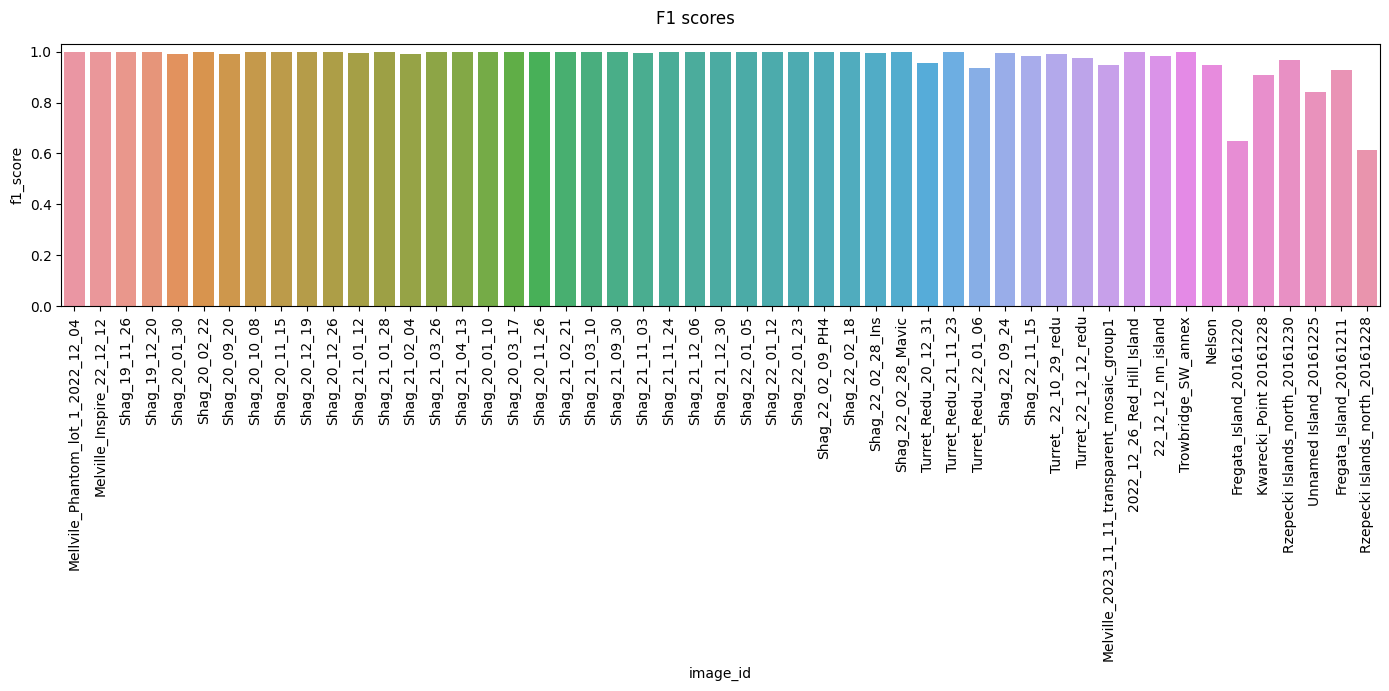

In [20]:
all_metrics_df = pd.read_csv(settings.result_path / model_name / "all_metrics.csv")

fig = plt.figure(figsize=(14, 7))
fig.suptitle(f'F1 scores')
plot = sns.barplot(
    data = all_metrics_df,
    x = "image_id",
    y = "f1_score",
    # width = 0.5,
)
plt.setp(plot.get_xticklabels(), rotation=90)
plt.ylim(0, 1.03)
plt.tight_layout()

# for container in plot.containers:
    # plot.bar_label(container, fmt="%.2f")